<h2>Классификаторы</h2>

Импорт библиотек

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Генерация сигналов

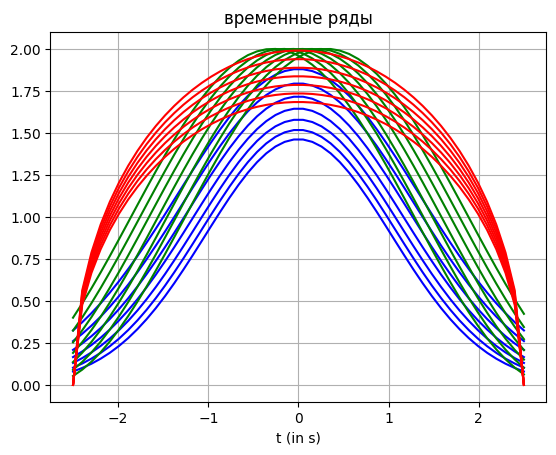

In [42]:
time_index = np.linspace(-5, 5, 50) * 0.5
tseries_list = {'Time': time_index}

for i in range(7):
    tseries_list["Tc"+str(i)] = np.exp(-time_index ** 2 / (2 * (28 / (21 + i)) ** 2)) * 1.41 * (28 / (21 + i))
for i in range(7):
    tseries_list["Ts"+str(i)] = np.sin(time_index + np.pi / 2 + (-np.pi + i) / 10) + 1
for i in range(7):
    tseries_list["Tp"+str(i)] = np.sqrt(6.25 - time_index ** 2) * (1 + (i - 16) / 49)

for i in range(7):
    plt.plot(time_index, tseries_list["Tc"+str(i)], '-b', label="Экспоненциальная")
for i in range(7):
    plt.plot(time_index, tseries_list["Ts"+str(i)], '-g', label="Синусоидная")
for i in range(7):
    plt.plot(time_index, tseries_list["Tp"+str(i)], '-r', label="Круглая")
            
plt.title('временные ряды')
plt.xlabel('t (in s)')
plt.grid()

Вычисление расстояния по формуле Евклида и DTW</h3>

In [44]:
def distance_matrix(x, y, q) -> np.array:
    """
    Функция  рассчета  матрицы  расстояний между точками двух рядов 
    """
    mdist = np.zeros((len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            mdist[i,j] = np.abs((x[j]-y[i]))**q
    return mdist

def DTW(x, x_s, q=1, isDTW=True):
    '''
        x: первый ряд
        x_s : второй ряд
        q : степень для вычисления базового расстояния
    '''
    N = len(x)
    dist = distance_matrix(x,x_s,q=2)
    
    R = [[0] * (N+1) for i in range(N+1)]
    for i in range(1,N): 
        R[i][0] = dist[i,0] + R[i-1][0] 
        R[0][i] = dist[0,i] + R[0][i-1]
    
    k = 0
    if isDTW:
        k = 1
    
    for i in range(1,N+1): 
        for j in range(1,N+1):
            R[i][j] = dist[i-1,j-1] + k*np.min([R[i-1][j-1], R[i][j-1], R[i-1][j]]) 

    pth = []
    i = N
    j = N
    while i >= 0 and j >= 0:
        pth.append((i,j))
        if R[i][j-1] <= R[i-1][j-1] and R[i][j-1] <= R[i-1][j]:
            I = i
            J = j-1                
        if R[i-1][j] <= R[i-1][j-1] and R[i-1][j] <= R[i][j-1]:
            I = i - 1
            J = j 
        if R[i-1][j-1] <= R[i][j-1] and R[i-1][j-1] <= R[i-1][j]:
            I = i - 1
            J = j - 1
        i = I
        j = J
        
    s = 0
    for l in pth:
        s += R[l[0]][l[1]]
    s = s/len(pth) 

    return s, pth, R

In [49]:
#Объект сравнения №1: Сигнал 1 экспоненциального типа
x = np.abs(tseries_list["Tc1"])

#Сигнал 2 экспоненциального типа
x_c = np.abs(tseries_list["Tc2"])
#Сигнал 3 синусоидного типа
x_s = np.abs(tseries_list["Ts3"])
#Сигнал 4 круглого типа
x_p = np.abs(tseries_list["Tp4"])

s1 = DTW(x, x_c, q=2)
s2 = DTW(x, x_s, q=2)
s3 = DTW(x, x_p, q=2)

print (f"DTW\nTc1 и Tc2 = {s1[0]}     Tc1 и Ts3 = {s2[0]}     Tc1 и Tp4 = {s3[0]}")

s11 = DTW(x, x_c, q=2, isDTW=False)
s12 = DTW(x, x_s, q=2, isDTW=False)
s13 = DTW(x, x_p, q=2, isDTW=False)

print (f"Dec\nTc1 и Tc2 = {s11[0]}     Tc1 и Ts3 = {s12[0]}     Tc1 и Tp4 = {s13[0]}")

DTW
Tc1 и Tc2 = 0.017734564519939305     Tc1 и Ts3 = 0.15907533198821797     Tc1 и Tp4 = 0.2367358426262459
Dec
Tc1 и Tc2 = 0.00131610091267554     Tc1 и Ts3 = 0.01943821242944858     Tc1 и Tp4 = 0.007871762388565653


Метод с DTW показал заметно большие результаты по сравнению с формулой Евклида. Исключением является сравнение экспоненциального и синусоидного сигналов, где формула Евклида показала большую разницу, чем DTW. Вынести связь сложно из-за недостатка данных

Отображение матриц весов расстояний Tc1 и Tc2

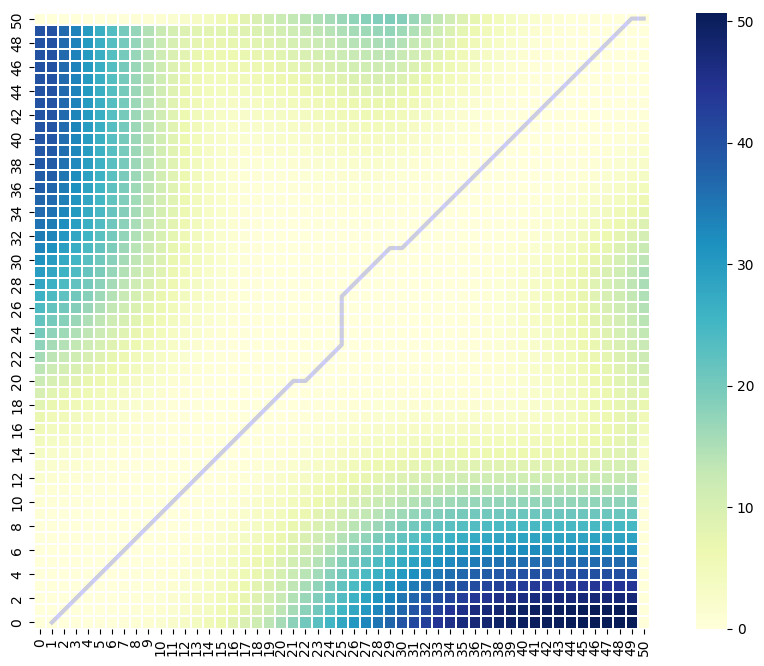

In [55]:
import seaborn as sbn
cost_matrix = s1[2]
warp_path = s1[1]

fig, ax = plt.subplots(figsize=(12, 8))
ax = sbn.heatmap(cost_matrix, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()


path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

# Align the path from the center of each cell
path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

ax.plot(path_xx, path_yy, color='blue', linewidth=3, alpha=0.2)

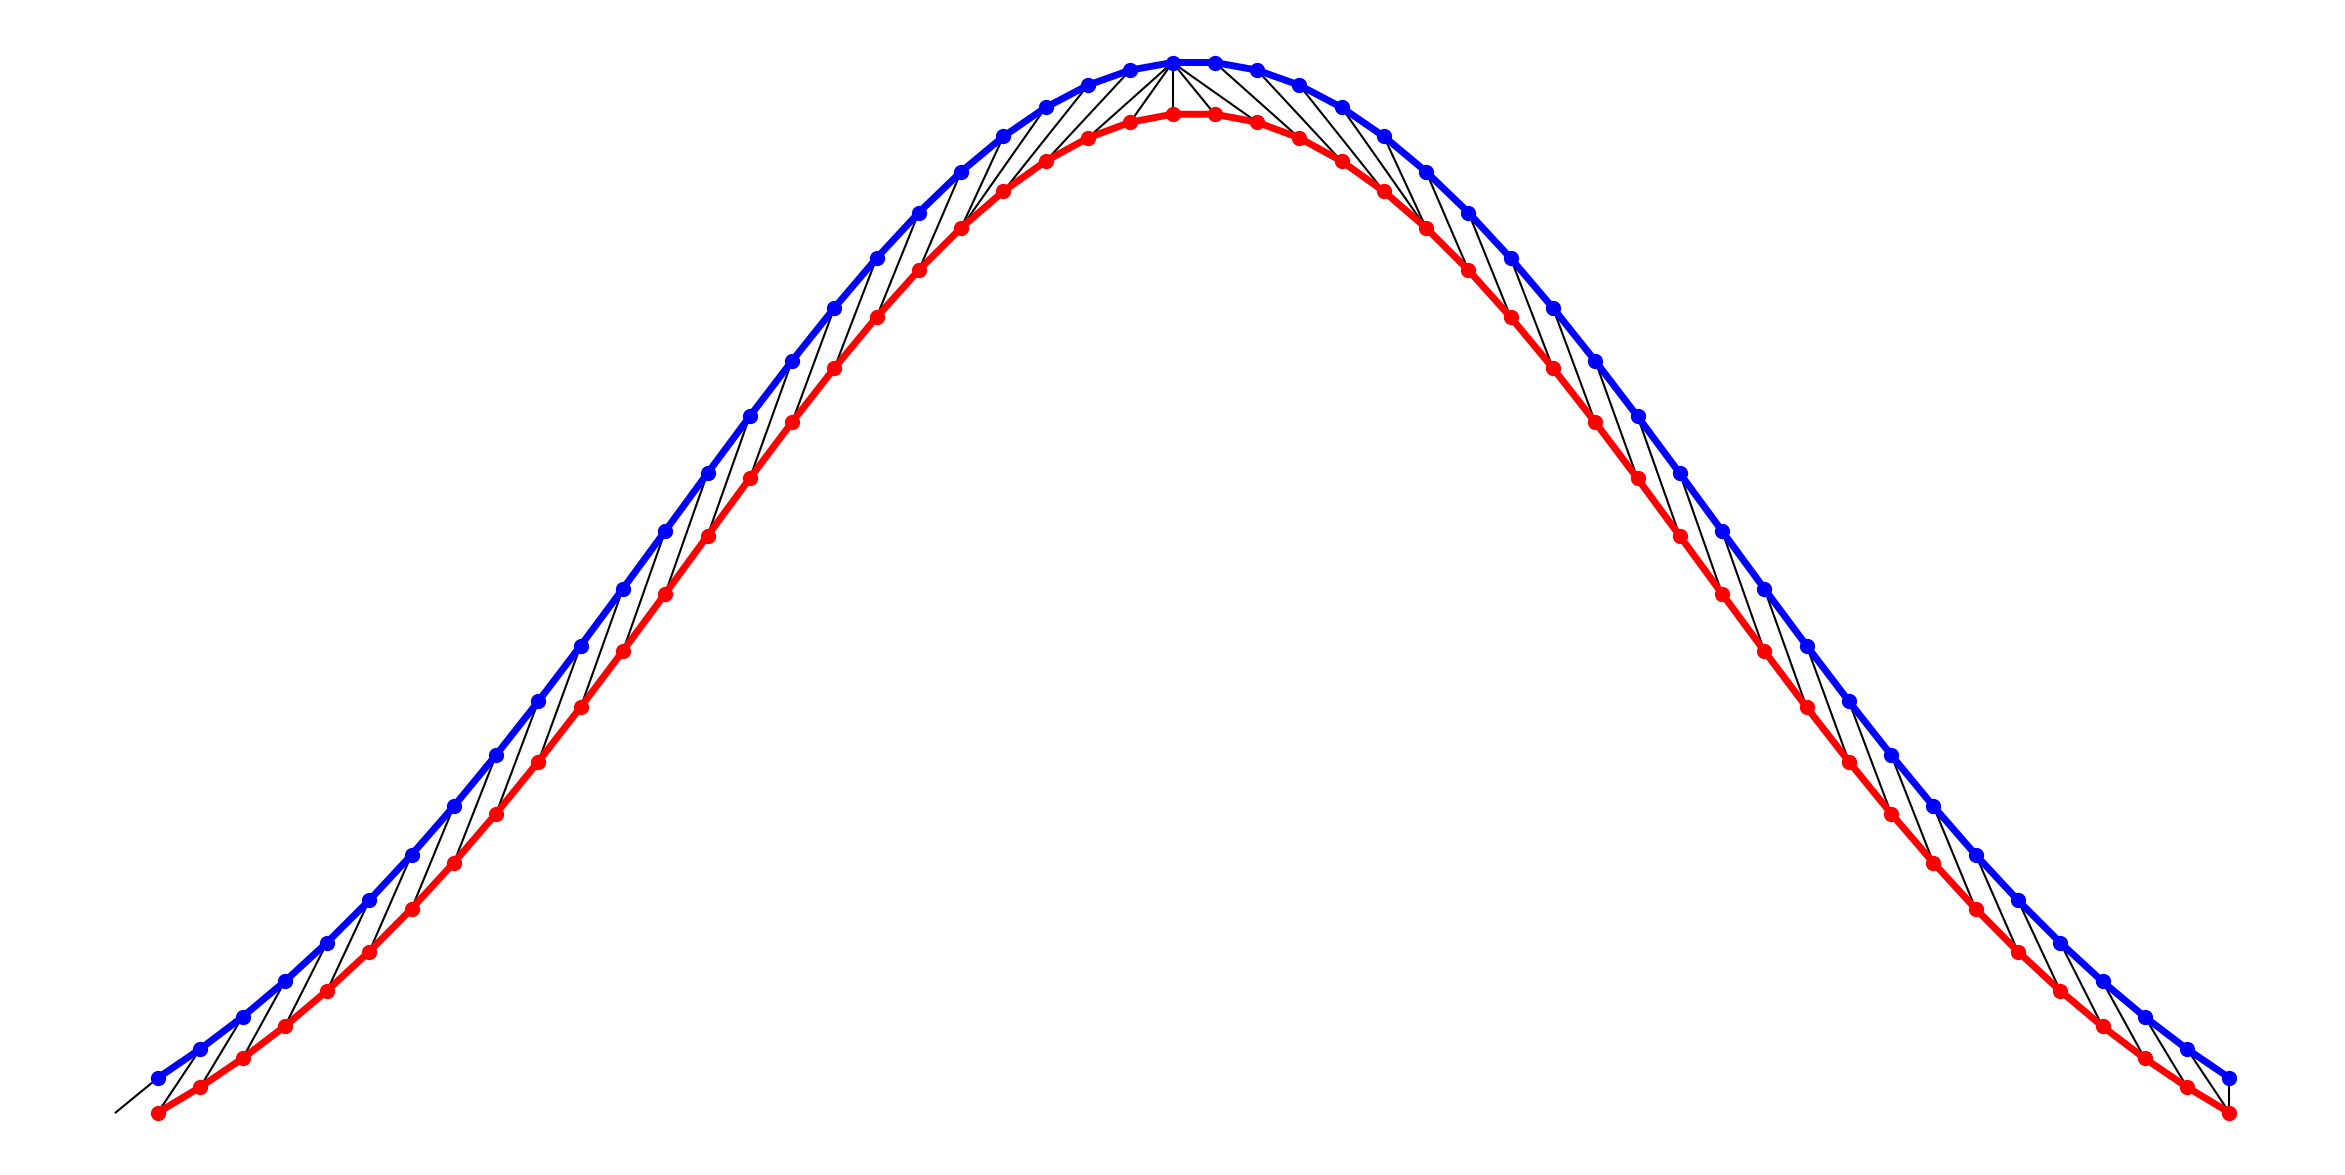

In [58]:
fig, ax = plt.subplots(figsize=(30, 15))

warp_path = s1[1]
x1 = x
x2 = x_c

# Remove the border and axes ticks
fig.patch.set_visible(True)
ax.axis('off')

for [map_x, map_y] in warp_path:   
    ax.set_facecolor('white')
    ax.plot([map_x-1, map_y-1], [x1[map_x-1], x2[map_y-1]], '-k')

ax.plot(x1, color='blue', marker='o', markersize=10, linewidth=5)
ax.plot(x2, color='red', marker='o', markersize=10, linewidth=5)
ax.tick_params(axis="both", which="major", labelsize=18)

Отображение матриц весов расстояний Tc1 и Ts3

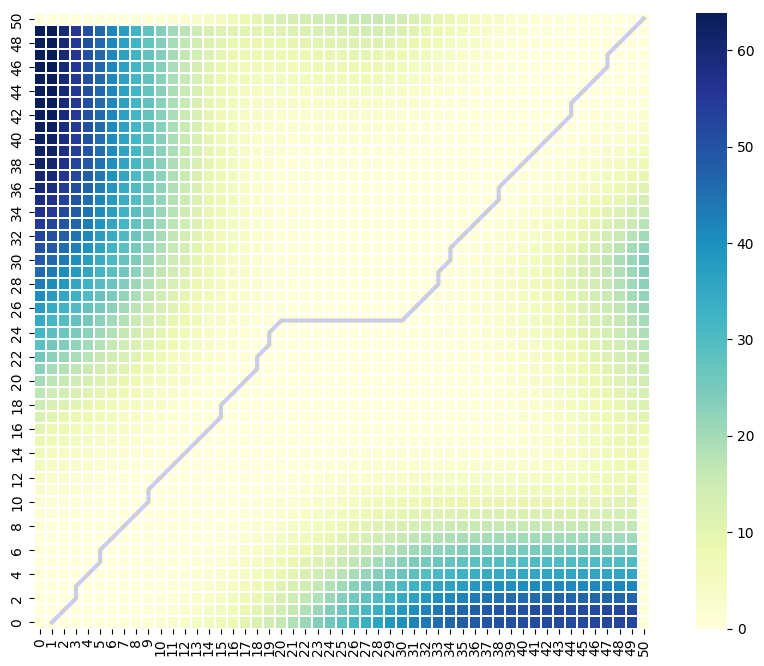

In [56]:
cost_matrix = s2[2]
warp_path = s2[1]

fig, ax = plt.subplots(figsize=(12, 8))
ax = sbn.heatmap(cost_matrix, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()


path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

# Align the path from the center of each cell
path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

ax.plot(path_xx, path_yy, color='blue', linewidth=3, alpha=0.2)

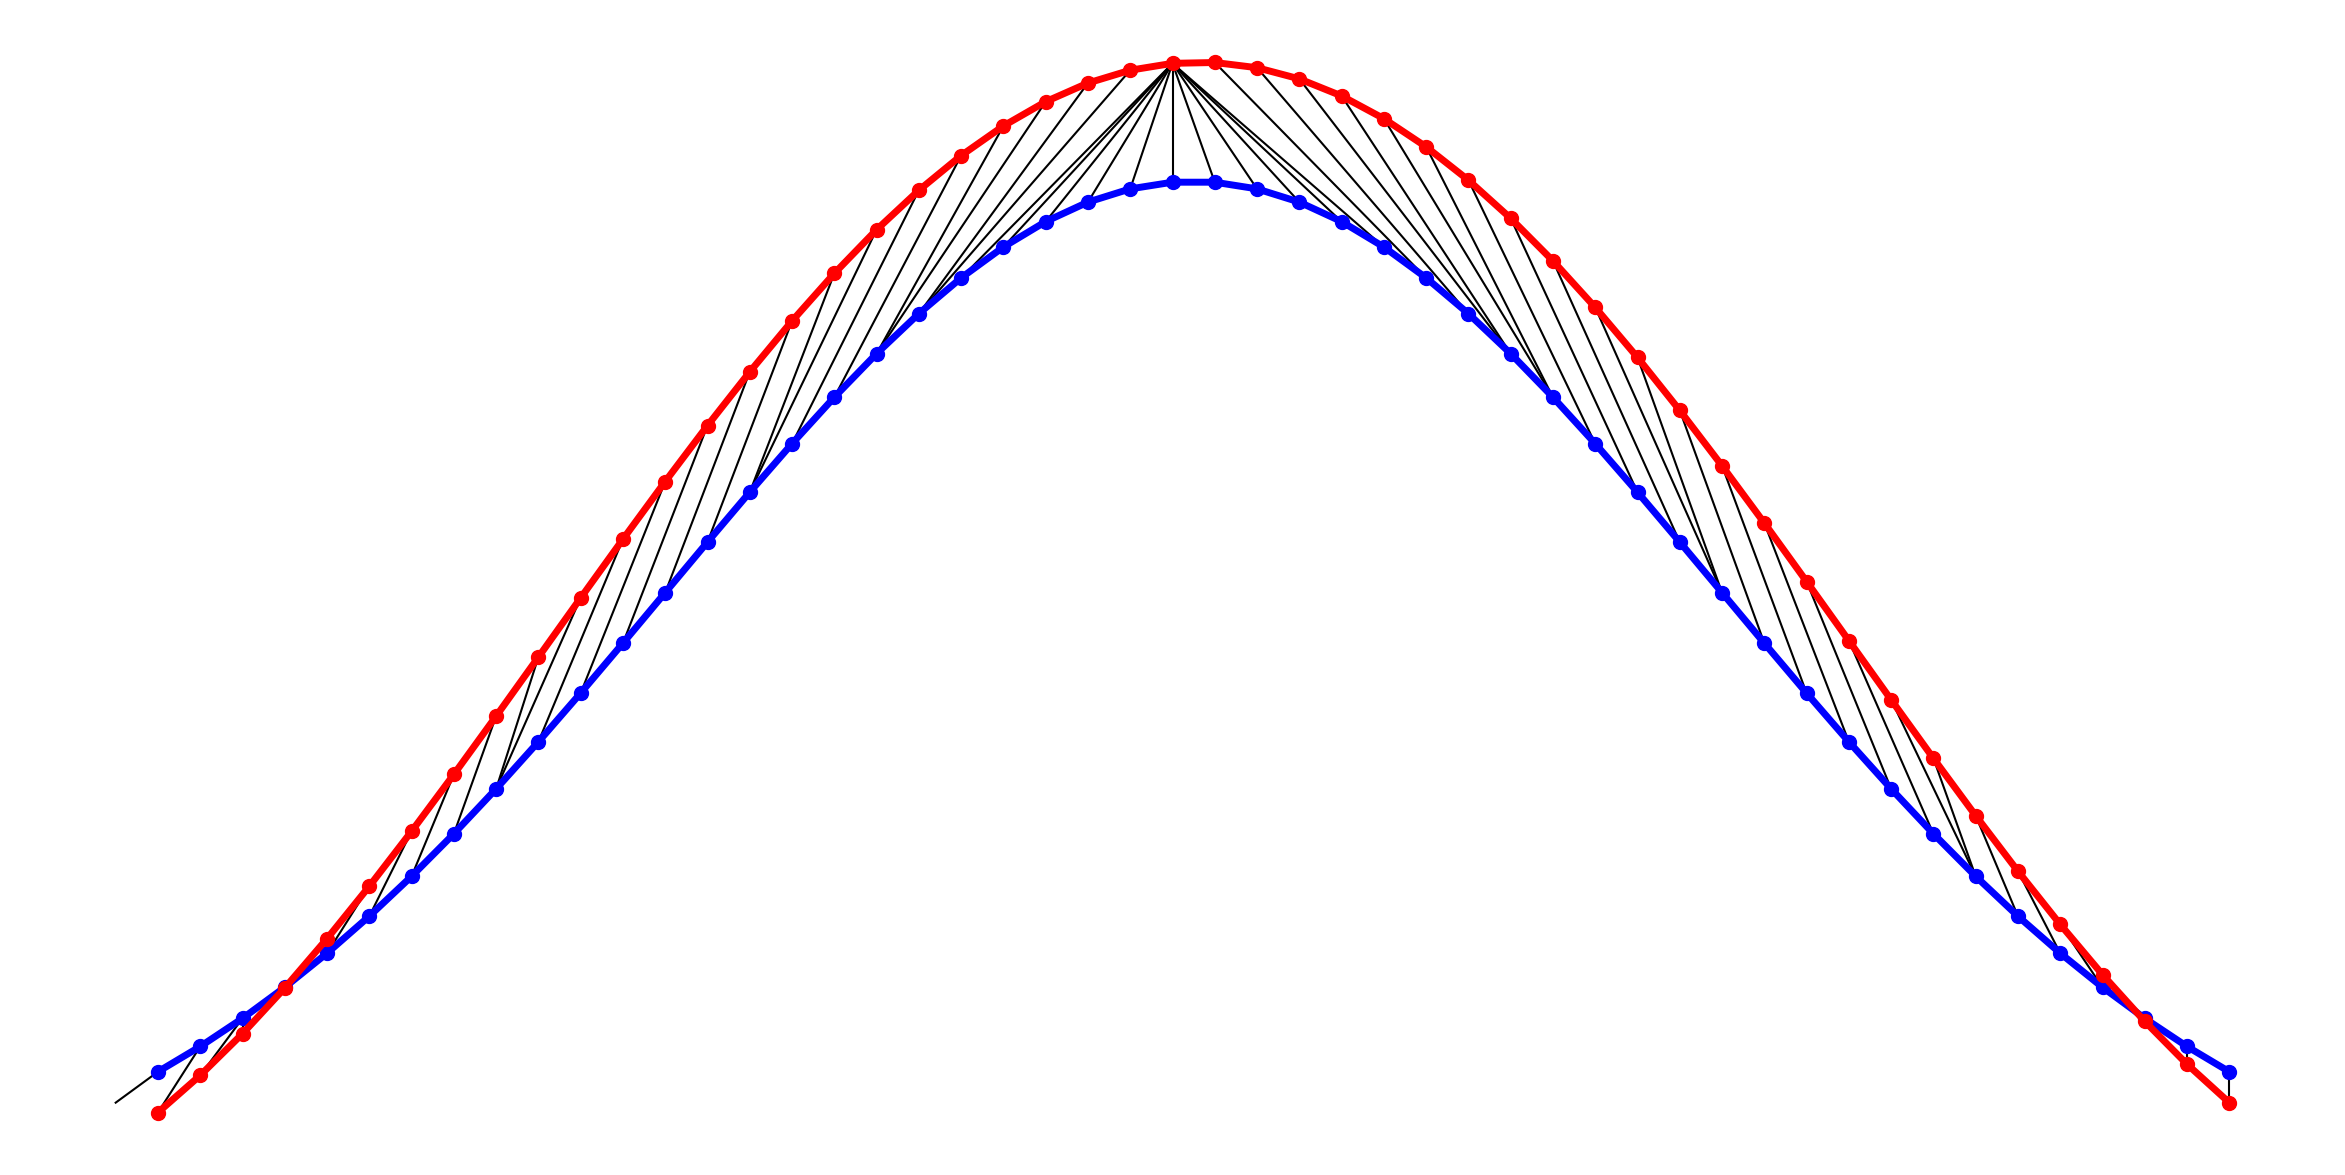

In [54]:
fig, ax = plt.subplots(figsize=(30, 15))

x1 = x
x2 = x_s

# Remove the border and axes ticks
fig.patch.set_visible(True)
ax.axis('off')

for [map_x, map_y] in warp_path:   
    ax.set_facecolor('white')
    ax.plot([map_x-1, map_y-1], [x1[map_x-1], x2[map_y-1]], '-k')

ax.plot(x1, color='blue', marker='o', markersize=10, linewidth=5)
ax.plot(x2, color='red', marker='o', markersize=10, linewidth=5)
ax.tick_params(axis="both", which="major", labelsize=18)

Отображение матриц весов расстояний Tc1 и Tp4

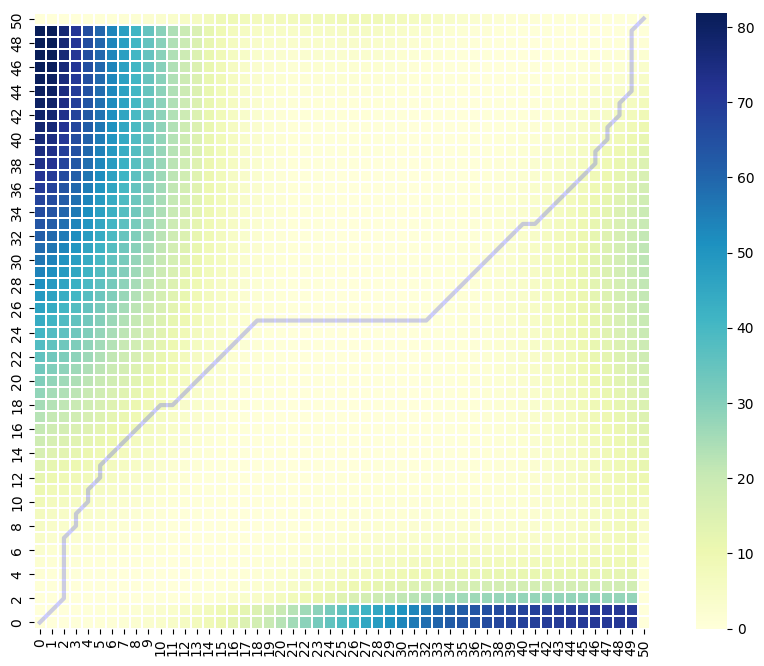

In [59]:
cost_matrix = s3[2]
warp_path = s3[1]

fig, ax = plt.subplots(figsize=(12, 8))
ax = sbn.heatmap(cost_matrix, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()


path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

# Align the path from the center of each cell
path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

ax.plot(path_xx, path_yy, color='blue', linewidth=3, alpha=0.2)

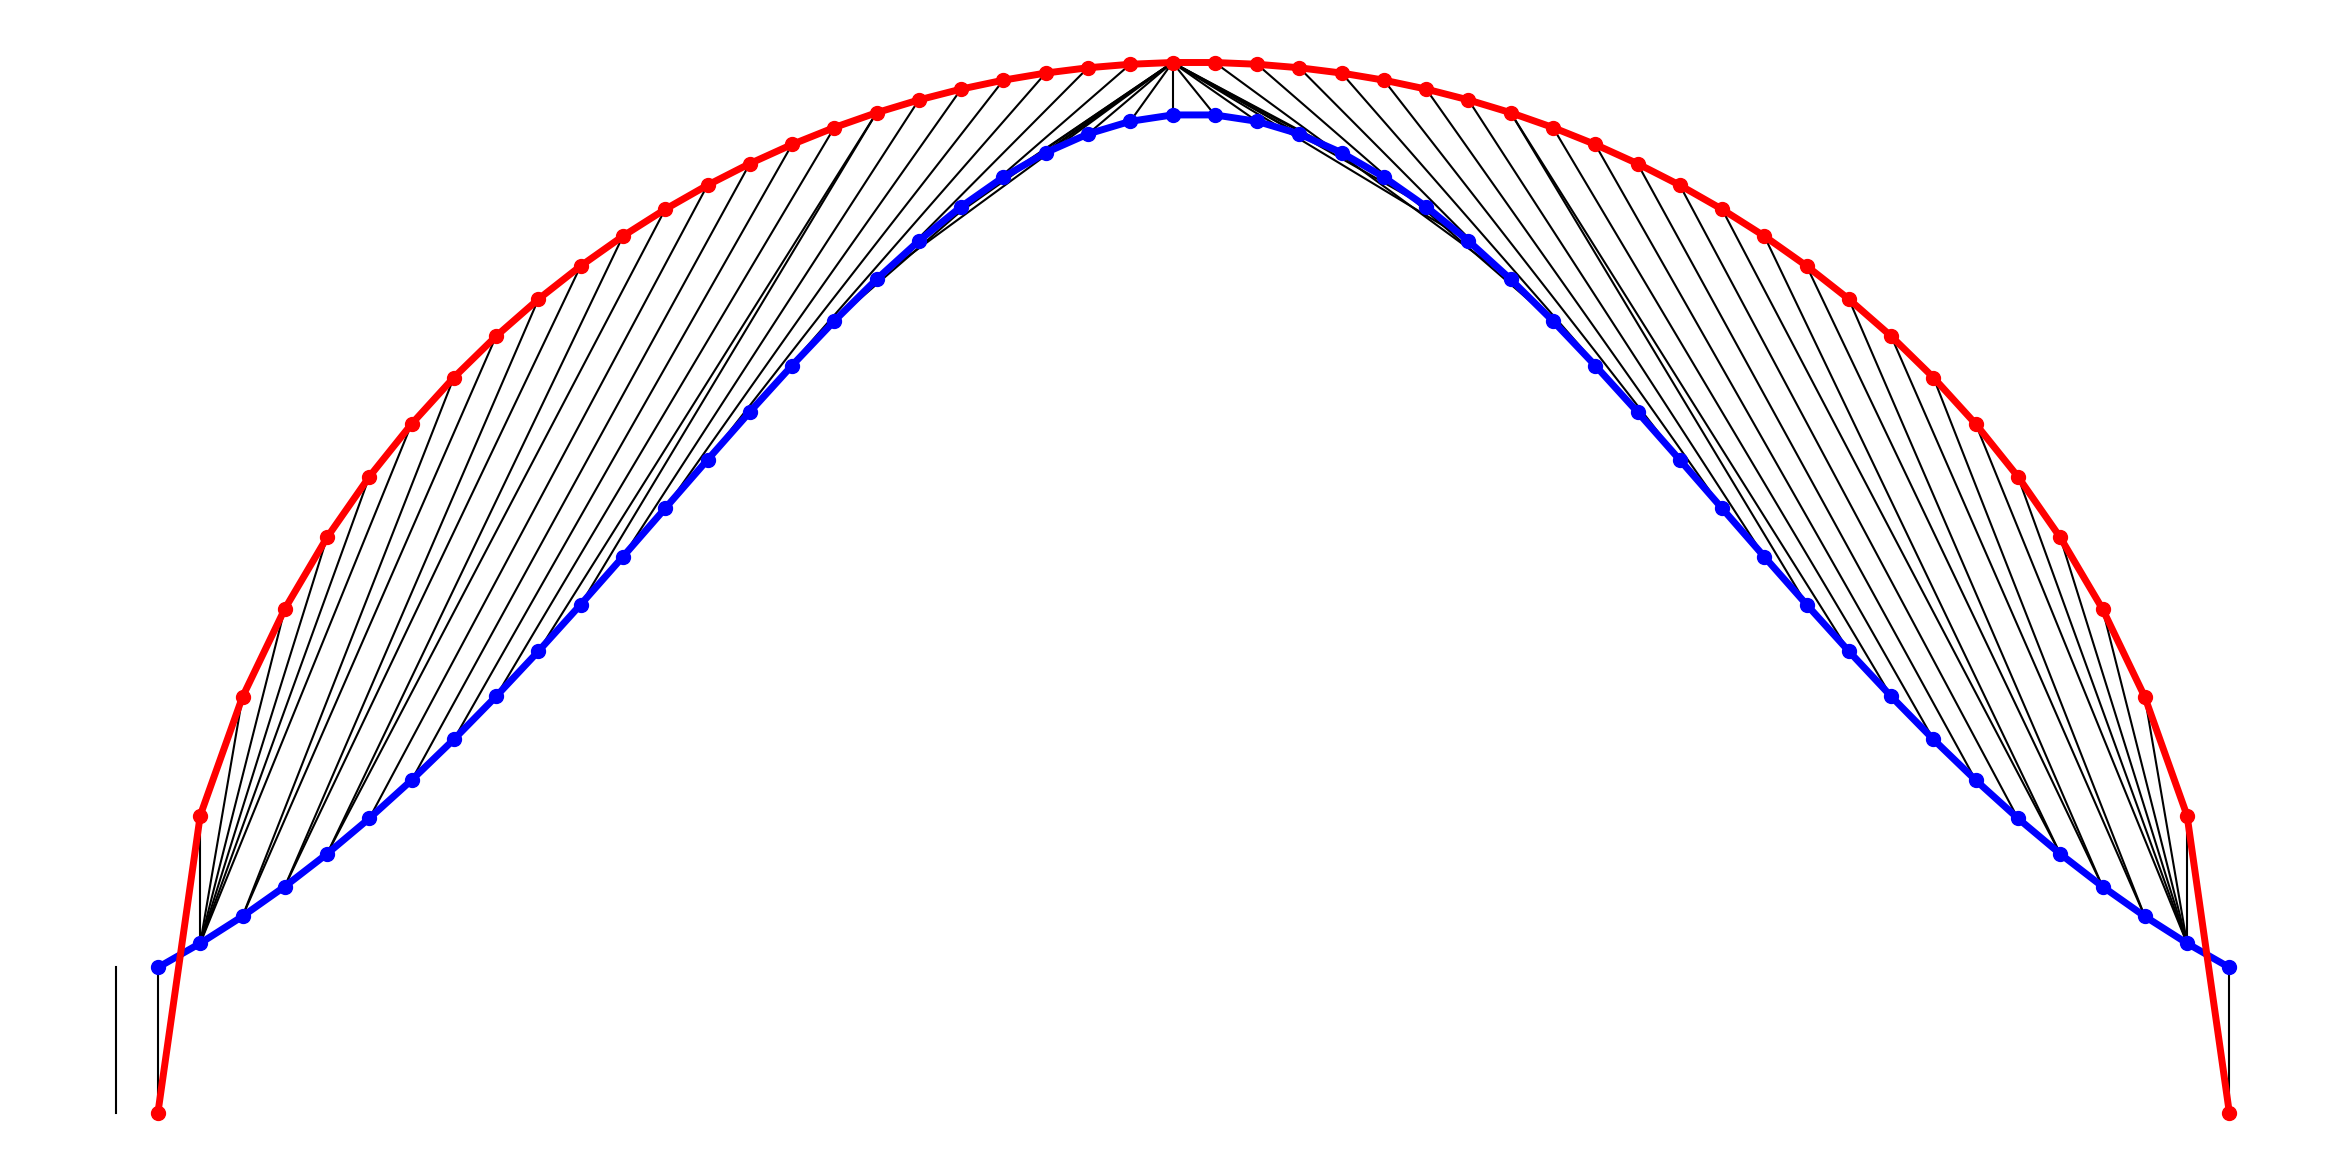

In [60]:
fig, ax = plt.subplots(figsize=(30, 15))

x1 = x
x2 = x_p

# Remove the border and axes ticks
fig.patch.set_visible(True)
ax.axis('off')

for [map_x, map_y] in warp_path:   
    ax.set_facecolor('white')
    ax.plot([map_x-1, map_y-1], [x1[map_x-1], x2[map_y-1]], '-k')

ax.plot(x1, color='blue', marker='o', markersize=10, linewidth=5)
ax.plot(x2, color='red', marker='o', markersize=10, linewidth=5)
ax.tick_params(axis="both", which="major", labelsize=18)

In [62]:
from dtaidistance import dtw
x = np.abs(tseries_list["Ts1"])
x_s = np.abs(tseries_list["Ts2"])

distance, paths = dtw.warping_paths(x, x_s)
print(distance)
print(paths)

0.08619395364108619
[[0.                inf        inf ...        inf        inf        inf]
 [       inf 0.04593097 0.1115869  ... 9.03493004 9.03855397 9.04039173]
 [       inf 0.04594249 0.07145375 ... 8.74567077 8.74816685 8.74921333]
 ...
 [       inf 8.74728851 8.40832835 ... 0.09689609 0.19142625 0.30600688]
 [       inf 8.75205389 8.4115563  ... 0.04720034 0.0918393  0.17795827]
 [       inf 8.75453591 8.41294197 ... 0.09460967 0.04722553 0.08619395]]


(<Figure size 1000x1000 with 4 Axes>, [<Axes: >, <Axes: >, <Axes: >, <Axes: >])

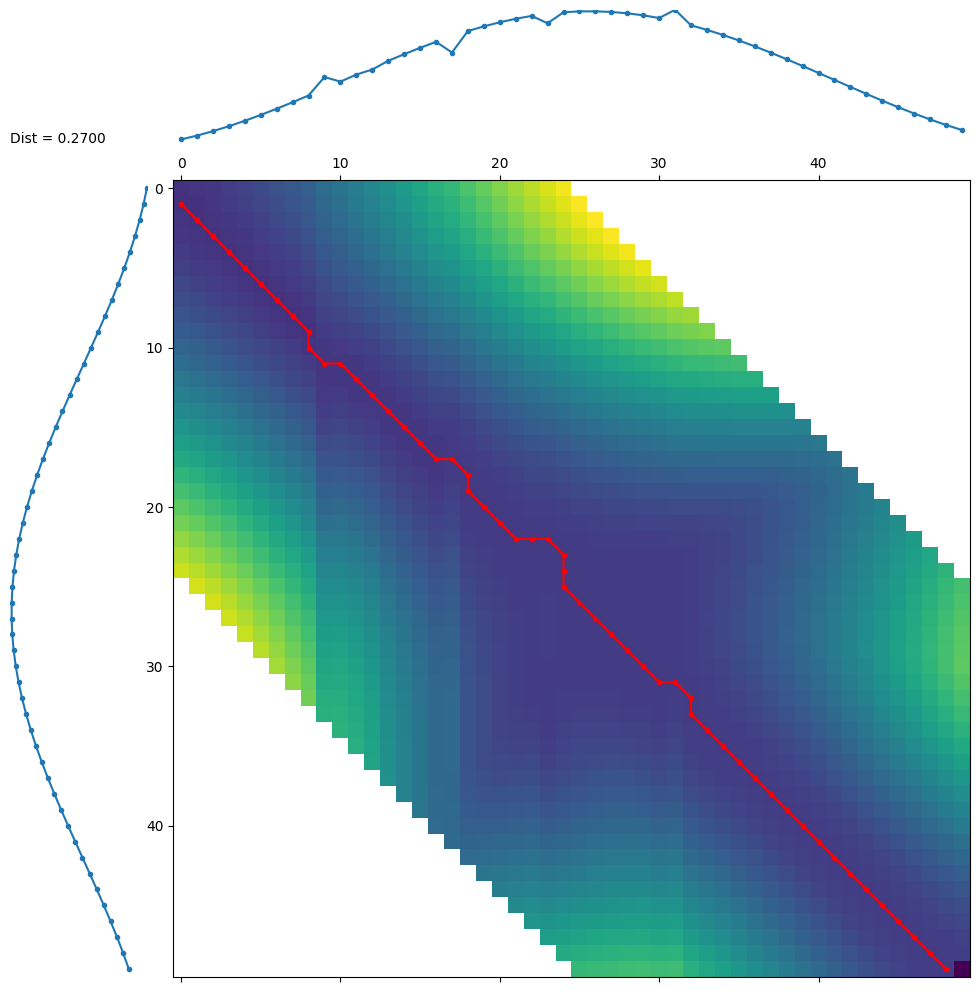

In [63]:
from dtaidistance import dtw_visualisation as dtwvis
import random
import numpy as np
xw = np.arange(0, 20, .5)
s1 = x
s2 = x_s
random.seed(1)
for idx in range(len(s2)):
    if random.random() < 0.05:
        s2[idx] += (random.random() - 0.5) / 2
d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path)

<h3>Обучение классификаторов</h3>

In [66]:
x = []  #значения
Y = []  # целевая переменная

for v in tseries_list:
    if v!= 'Time':
        x.append(tseries_list[v])
        c = v[:-1]
        if c == "Ts":
            Y.append(0)
        elif c == "Tc":
            Y.append(1)
        else: Y.append(2)

arr = np.arange(len(Y))
np.random.shuffle(arr)
print(Y)

X_train = []
X_test = []
y_train = []
y_test = []

for i in arr[:-5]:
    X_train.append(x[i])
    y_train.append(Y[i])

for i in arr[len(X_train):]:
    X_test.append(x[i])
    y_test.append(Y[i])

[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2]


Классификатор DTW

In [69]:
from pyts.classification import KNeighborsClassifier

clf = KNeighborsClassifier(metric='dtw')
clf.fit(X_train, y_train)

print(f"Accuracy {clf.score(X_test, y_test)}")
print()
for i in range(len(X_test)):
    print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(X_test[i].reshape(1, -1))}")
    print(f"Истинный класс для предсказаний {y_test[i]}")
    print()

Accuracy 1.0

Вектор вероятности принадлежности к классам [[0. 0. 1.]]
Истинный класс для предсказаний 2

Вектор вероятности принадлежности к классам [[0. 1. 0.]]
Истинный класс для предсказаний 1

Вектор вероятности принадлежности к классам [[0. 0. 1.]]
Истинный класс для предсказаний 2

Вектор вероятности принадлежности к классам [[0. 0. 1.]]
Истинный класс для предсказаний 2

Вектор вероятности принадлежности к классам [[1. 0. 0.]]
Истинный класс для предсказаний 0



Классификатор kNN

In [71]:
clf = KNeighborsClassifier(metric='minkowski')
clf.fit(X_train, y_train)

print(f"Accuracy {clf.score(X_test, y_test)}")
print()
for i in range(len(X_test)):
    print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(X_test[i].reshape(1, -1))}")
    print(f"Истинный класс для предсказаний {y_test[i]}")
    print()

Accuracy 1.0

Вектор вероятности принадлежности к классам [[0. 0. 1.]]
Истинный класс для предсказаний 2

Вектор вероятности принадлежности к классам [[0. 1. 0.]]
Истинный класс для предсказаний 1

Вектор вероятности принадлежности к классам [[0. 0. 1.]]
Истинный класс для предсказаний 2

Вектор вероятности принадлежности к классам [[0. 0. 1.]]
Истинный класс для предсказаний 2

Вектор вероятности принадлежности к классам [[1. 0. 0.]]
Истинный класс для предсказаний 0



TimeSeriesForest

In [74]:
from pyts.classification import TimeSeriesForest

clf = TimeSeriesForest(random_state=43)
clf.fit(X_train, y_train)

print(f"Accuracy {clf.score(X_test, y_test)}")
print()
for i in range(len(X_test)):
    print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(X_test[i].reshape(1, -1))}")
    print(f"Истинный класс для предсказаний {y_test[i]}")
    print()

Accuracy 1.0

Вектор вероятности принадлежности к классам [[0.068 0.126 0.806]]
Истинный класс для предсказаний 2

Вектор вероятности принадлежности к классам [[0.01 0.99 0.  ]]
Истинный класс для предсказаний 1

Вектор вероятности принадлежности к классам [[0.11  0.248 0.642]]
Истинный класс для предсказаний 2

Вектор вероятности принадлежности к классам [[0.09  0.184 0.726]]
Истинный класс для предсказаний 2

Вектор вероятности принадлежности к классам [[0.85  0.106 0.044]]
Истинный класс для предсказаний 0



Три рассматриваемых метода показали одинаково точные результаты. Точность во всех трёх случаях составляет 1.0
Классификаторы KNN и DTW показали равные вектора вероятности принадлежности к классам.